CLPP threshold sweep: 100%|██████████| 30/30 [02:39<00:00,  5.31s/it]


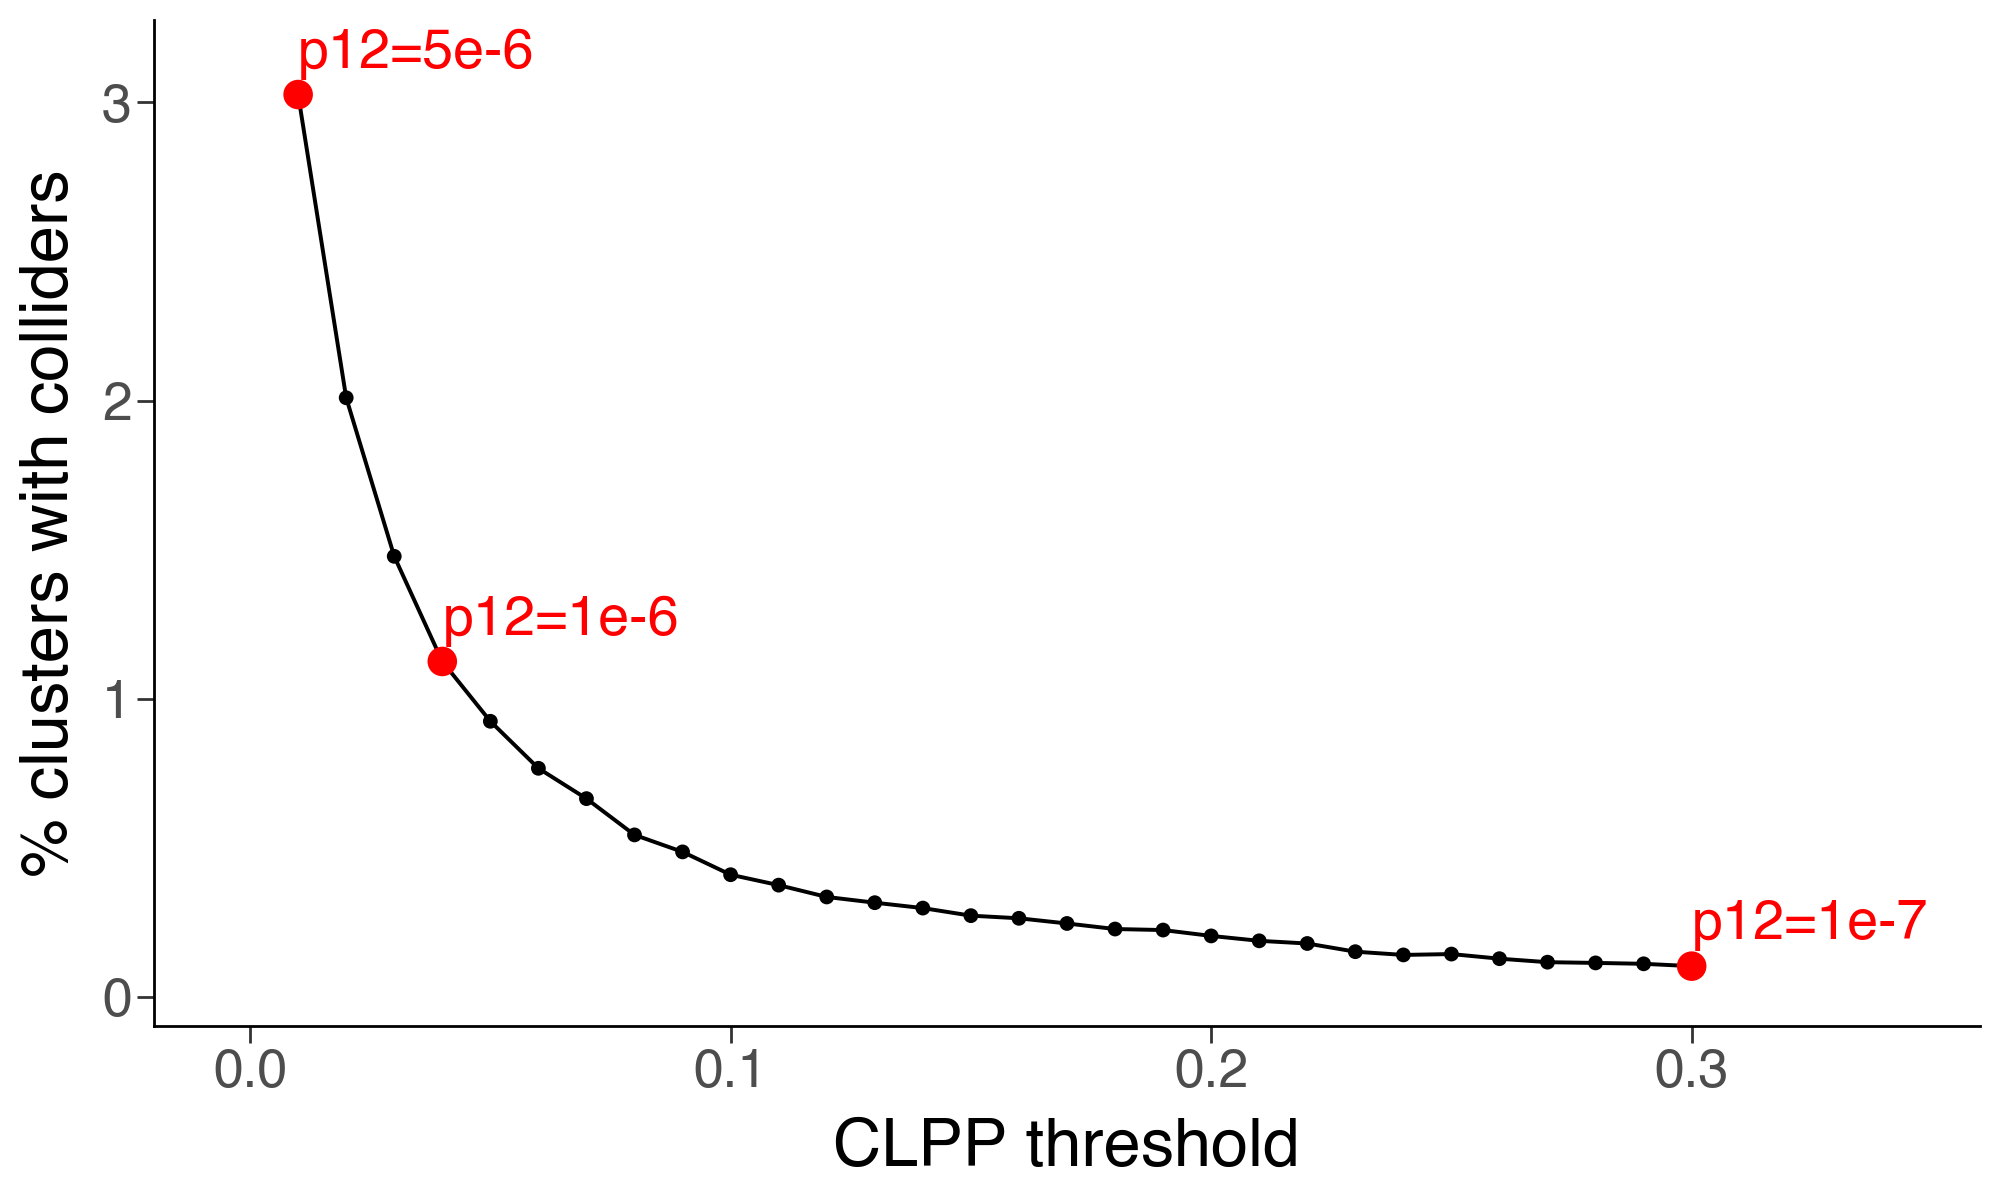

In [1]:
import gc, re
from collections import Counter

import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
from plotnine import scale_y_continuous
from plotnine import (
    ggplot, aes, geom_line, geom_point, geom_text,
    scale_x_continuous, labs, theme_classic, theme, element_text
)

bk = lambda s: "_".join(s.rsplit("_", 1)[:-1])         

def pct_dup_clusters(df_edges: pd.DataFrame) -> float:
    if df_edges.empty:
        return 0.0

    g = nx.from_pandas_edgelist(df_edges, "signal_a", "signal_b")

    cs_keys = {
    "_".join(node.rsplit('_', 1)[:-1])
    for node in g.nodes
    }

    dup, total = 0, 0   
    for comp in nx.connected_components(g):
        total += 1
        nodes = list(comp)
        key_counts = Counter(n.rsplit('_', 1)[0] for n in nodes)
        if any(k in cs_keys and cnt >= 2 for k, cnt in key_counts.items()):
            dup += 1
    return dup / total * 100.0 if total else 0.0

thr_values = [(i + 1) / 100 for i in range(30)]       

clpp_file   = "../data/ge_ge_clpp.tsv"
prior_files = {
    "5e-6": "../data/ge_ge_results_5e-6_0.8.tsv",
    "1e-6": "../data/ge_ge_results_1e-6_0.8.tsv",
    "1e-7": "../data/ge_ge_results_1e-7_0.8.tsv",
}
prior_thr   = {"5e-6": 0.01, "1e-6": 0.04, "1e-7": 0.30}

df_clpp = pd.read_csv(clpp_file, sep="\t")

df_clpp = df_clpp[df_clpp["signal_a"]!= df_clpp["signal_b"]]

thr_dup_pct = []
for t in tqdm(thr_values, desc="CLPP threshold sweep"):
    sel = df_clpp[df_clpp.clpp > t][["signal_a", "signal_b"]]
    thr_dup_pct.append(pct_dup_clusters(sel))
    gc.collect()


prior_dup_pct = {}
for prior, path in prior_files.items():
    df = pd.read_csv(path, sep="\t")
    df = df[df["PP.H4"] >= 0.8]                             
    sel = df[["signal1", "signal2"]].rename(
        columns={"signal1": "signal_a", "signal2": "signal_b"}
    )
    prior_dup_pct[prior] = pct_dup_clusters(sel)
    gc.collect()

df_pts = pd.DataFrame({
    "threshold": [prior_thr[p] for p in prior_files],
    "dup_pct"  : [prior_dup_pct[p] for p in prior_files],
    "label"    : list(prior_files.keys())
})


bar_df = pd.DataFrame({"threshold": thr_values, "dup_pct": thr_dup_pct})

subset = df_pts

key_thr = {0.01: "p12=5e-6", 0.04: "p12=1e-6", 0.30: "p12=1e-7"}
subset = bar_df[bar_df.threshold.isin(key_thr)]
subset = subset.assign(label=subset.threshold.map(key_thr))

(
    ggplot(bar_df, aes("threshold", "dup_pct"))
    + geom_line(size=.8)
    + geom_point(size=2)
    + geom_point(data=subset,
                 mapping=aes("threshold", "dup_pct"),
                 color="red", size=5)
    + geom_text(data=subset,
                mapping=aes("threshold", "dup_pct", label="label"),
                nudge_y=0.05, ha="left", va="bottom", size=20, color="red")
    + scale_x_continuous(expand=(0, 0.03, 0, 0.06))
    + scale_y_continuous(expand=(0, 0.2))

    + labs(x="CLPP threshold", y="% clusters with colliders")
    + theme_classic(base_size=24)
    + theme(figure_size=(10, 6))
)

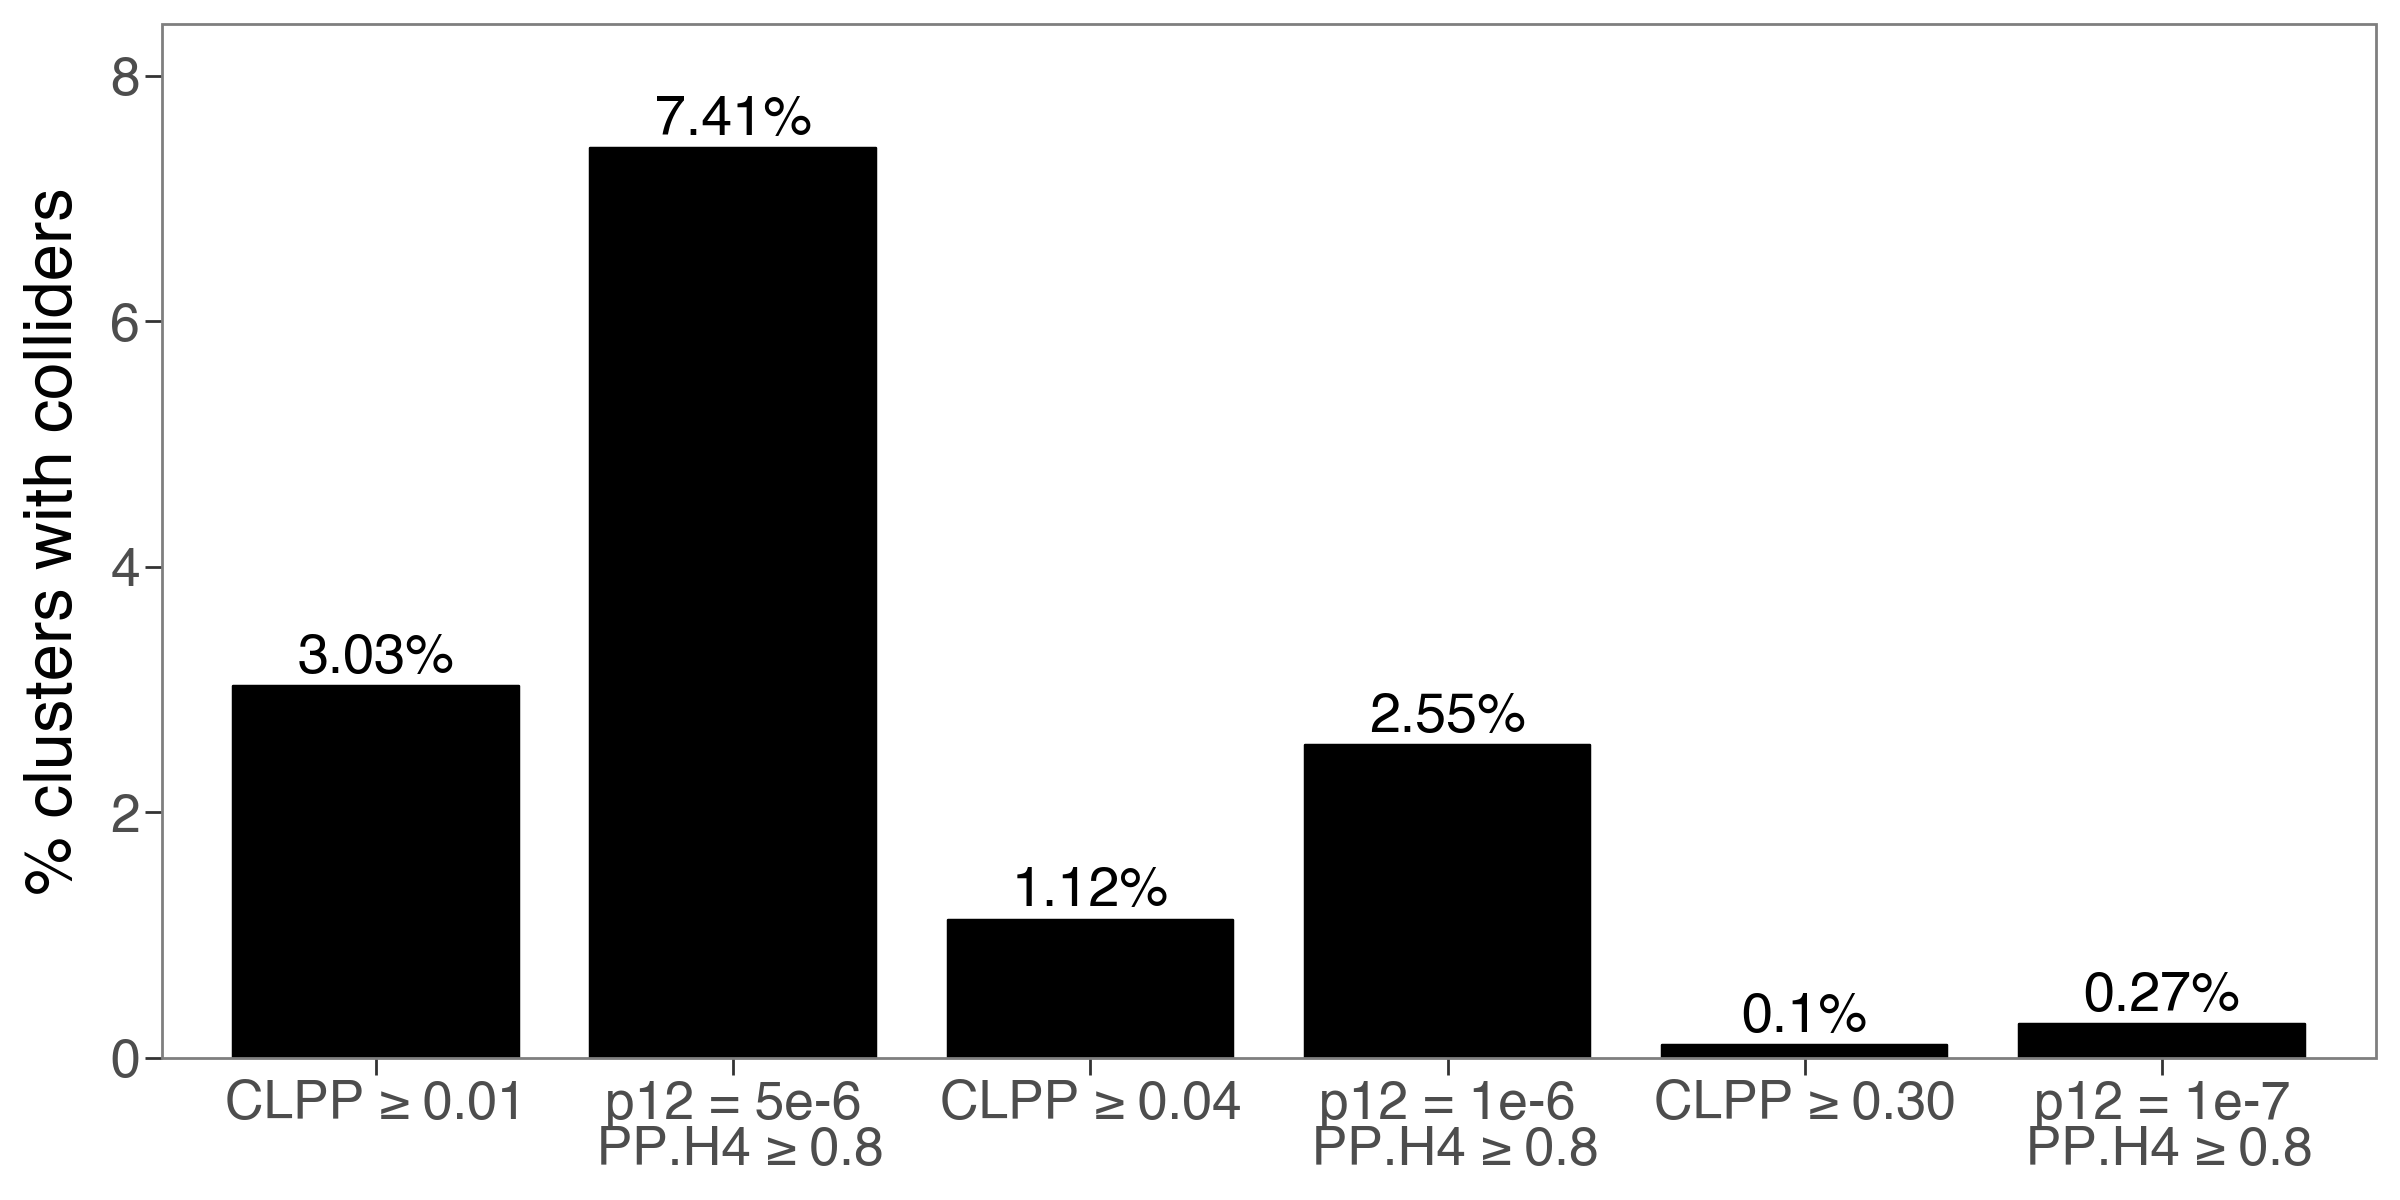

In [2]:
from plotnine import (
    ggplot, aes, geom_bar, labs, scale_fill_manual, theme_bw, theme,
    element_text, element_blank
)

key_thr   = [0.01, 0.04, 0.30]                    
prior_map = {0.01: '5e-6', 0.04: '1e-6', 0.30: '1e-7'}

thr2dup = dict(zip(thr_values, thr_dup_pct))     

rows = []
for t in key_thr:
    rows.append({"Bar": f"CLPP ≥ {t:.2f}",
                 "Method": "CLPP",
                 "dup_pct": thr2dup[t]})
    rows.append({"Bar": f"p12 = {prior_map[t]}\n PP.H4 ≥ 0.8",
                 "Method": "p12",
                 "dup_pct": prior_dup_pct[prior_map[t]]})

bar_df = pd.DataFrame(rows)

bar_order = ["CLPP ≥ 0.01", "p12 = 5e-6\n PP.H4 ≥ 0.8",
             "CLPP ≥ 0.04", "p12 = 1e-6\n PP.H4 ≥ 0.8",
             "CLPP ≥ 0.30", "p12 = 1e-7\n PP.H4 ≥ 0.8"]
bar_df["Bar"] = pd.Categorical(bar_df["Bar"], bar_order, ordered=True)

bar_df['label'] = (bar_df['dup_pct']).round(2).astype(str) + '%'

(
    ggplot(bar_df, aes("Bar", "dup_pct", fill="Method"))
    + geom_bar(stat="identity", width=.8, colour="black", show_legend=False)
    + geom_text(aes(label="label"), 
                va="bottom",            
                nudge_y=0.01,           
                size=20)                
    + scale_fill_manual(values={"CLPP": "#000000", "p12": "#000000"})
    + scale_y_continuous(expand=(0, 0, 0,1))
    + labs(x="", y="% clusters with colliders")
    + theme_bw(base_size=24)
    + theme(
        figure_size=(12, 6),
        panel_grid=element_blank()
    )
)

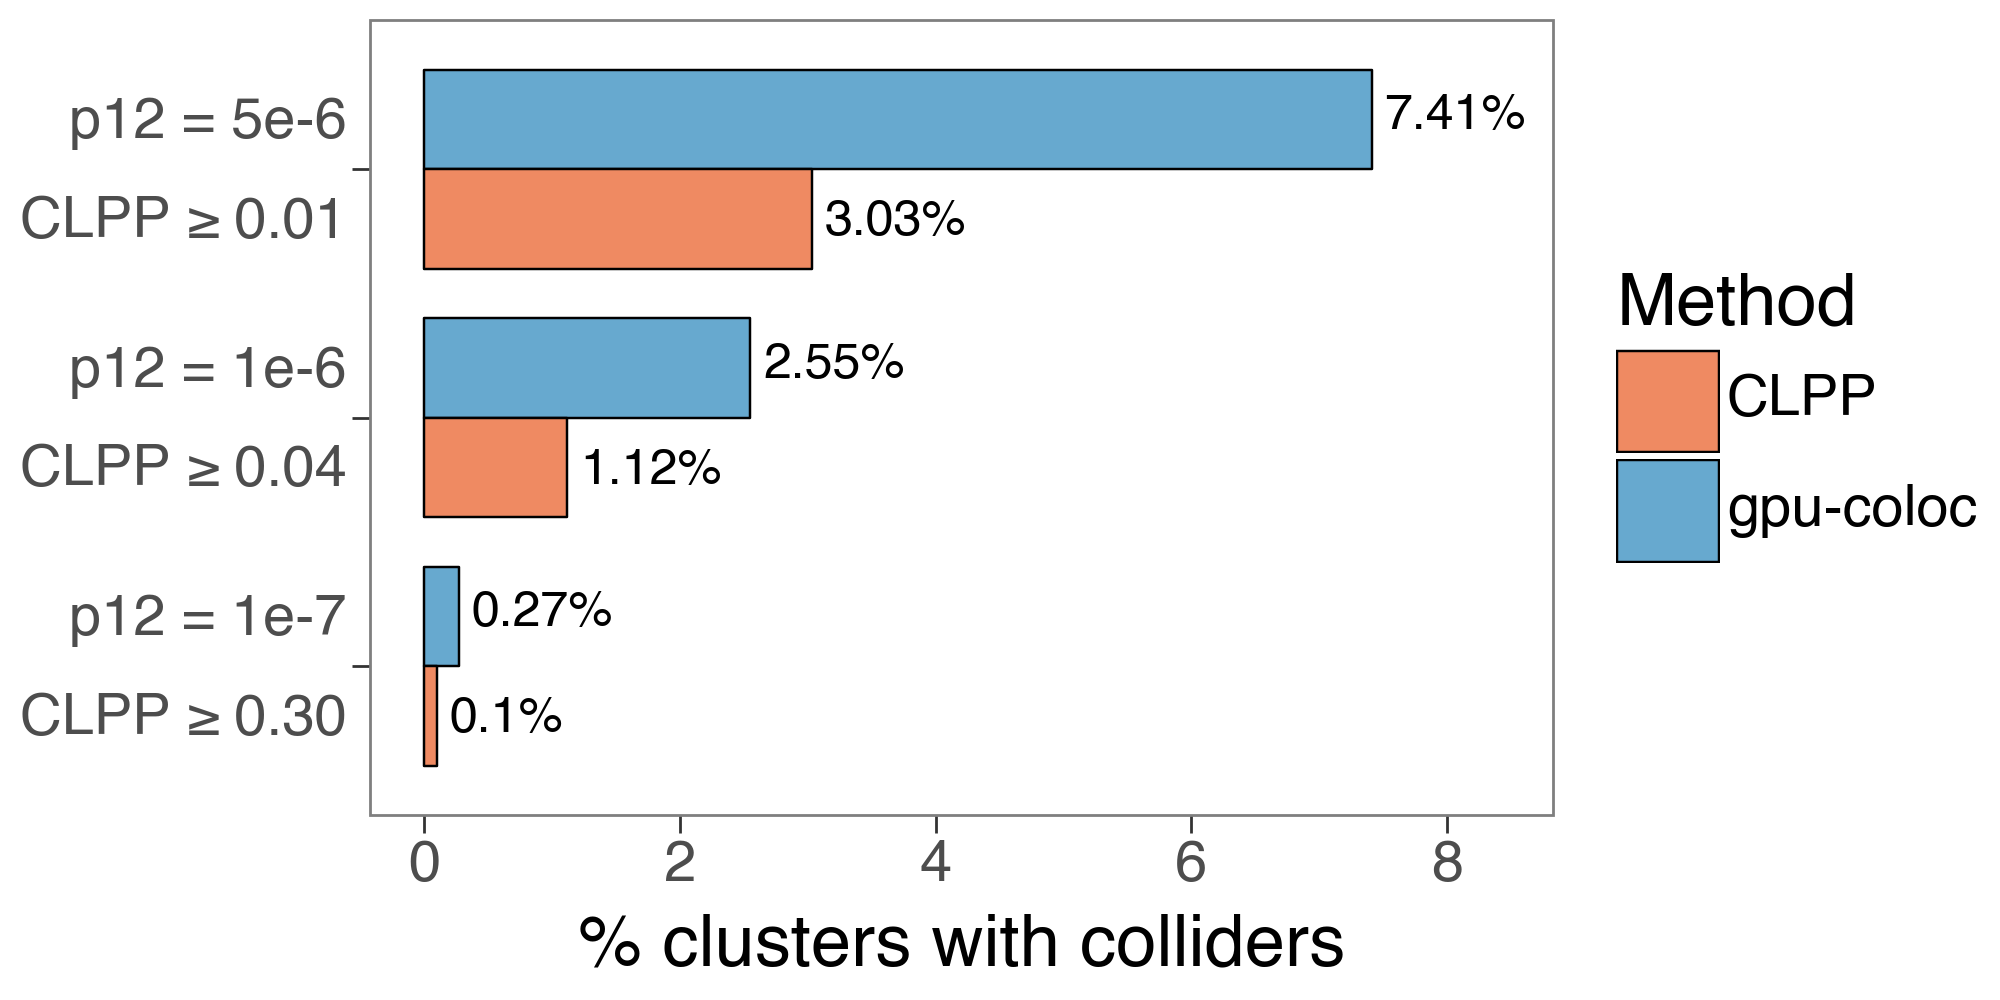

In [5]:
from plotnine import *
import pandas as pd

key_thr      = [0.30, 0.04, 0.01]#[0.01, 0.04, 0.30]
prior_map    = {0.01: '5e-6', 0.04: '1e-6', 0.30: '1e-7'}

thr_dup_pct      = {0.01: 3.03, 0.04: 1.12, 0.30: 0.1}        # CLPP %
prior_dup_pct    = {'5e-6': 7.41, '1e-6': 2.55, '1e-7': 0.27}  # p12  %

rows = []
for t in key_thr:
    rows.append({'Threshold': f'p12 = {prior_map[t]}\n\nCLPP ≥ {t:.2f}',        
                 'Method': 'CLPP',
                 'dup_pct': thr_dup_pct[t]})
    rows.append({'Threshold': f'p12 = {prior_map[t]}\n\nCLPP ≥ {t:.2f}',
                 'Method': 'gpu-coloc',
                 'dup_pct': prior_dup_pct[prior_map[t]]})

df = pd.DataFrame(rows)

threshold_labels = [f'p12 = {prior_map[t]}\n\nCLPP ≥ {t:.2f}' for t in key_thr]
df['Threshold'] = pd.Categorical(df['Threshold'], categories=threshold_labels, ordered=True)

df['label'] = df['dup_pct'].round(2).astype(str) + '%'

pad = 0.1                            

df['dup_pct_labpos'] = df['dup_pct'] + pad   


(
    ggplot(df, aes('Threshold', 'dup_pct', fill='Method'))
    + geom_bar(stat='identity', width=.8, position='dodge', colour='black')
    + geom_text(
        aes(y='dup_pct_labpos', label='label'),   
        position=position_dodge(width=.85),
        ha='left',       
        size=18
    )
    + coord_flip()                
    + expand_limits(y=df['dup_pct'].max() + 1)  
    + scale_fill_manual(values={'CLPP': '#ef8a62', 'gpu-coloc': '#67a9cf'})
    + labs(x='', y='% clusters with colliders')
    + theme_bw(base_size=26)
    + theme(panel_grid=element_blank(), figure_size=(10, 5))
)


In [20]:
df

,Threshold,Method,dup_pct,label
0,≥ 0.01,CLPP,2.55,2.55%
1,≥ 0.01,p12,1.13,1.13%
2,≥ 0.04,CLPP,1.20,1.2%
3,≥ 0.04,p12,0.90,0.9%
4,≥ 0.30,CLPP,1.12,1.12%
5,≥ 0.30,p12,0.75,0.75%
